# Мэтчинг товаров по описанию

Решение для хакатона  
Заказчик: компания "Просепт", специализирующаяся на выпуске профессиональной химии

## Вступление

### Описание проблемы

Заказчик производит несколько сотен различных товаров и продает их через дилеров. Дилеры занимаются розничной продажей в крупных сетях магазинов и на онлайн-площадках.  
Заказчик периодически собирает информацию о том, как дилеры продают их товар. Зачастую описание товаров на сайтах дилеров отличаются от того описания, что дает заказчик. Например, могут добавляться новый слова (“универсальный”, “эффективный”), объём (0.6 л -> 600 мл). Поэтому сопоставление товаров дилеров с товарами производителя заказчик делает вручную.

Необходимо разработать решение, которое отчасти автоматизирует процесс сопоставления товаров. Основная идея — предлагать несколько товаров заказчика, которые с наибольшей вероятностью соответствуют товару дилера.

Необходимо разработать веб-сервис, использующий ML-модель.  
Для каждого товара производителя сервис должен предлагать несколько (настраиваемое количество) вариантов соответствия из списка товаров дилеров.  
В случае, если среди товаров-кандидатов не найдется правильного товара для мэтчинга, оператор должен вручную найти соответствующий товар.

---

### Описание данных

**marketing_dealer** — список дилеров

**marketing_dealerprice** — результат работы парсера площадок дилеров:
  - `product_key` — уникальный номер позиции
  - `price` — цена
  - `product_url` — адрес страницы, откуда собраны данные
  - `product_name` — заголовок продаваемого товара
  - `date - дата` — получения информации
  - `dealer_id` — идентификатор дилера (внешний ключ к marketing_dealer)
  
**marketing_product** — список товаров, которые производит и распространяет заказчик;
  - `article` — артикул товара
  - `ean_13` — код товара (см. EAN 13)
  - `name` — название товара
  - `cost` — стоимость
  - `min_recommended_price` — рекомендованная минимальная цена
  - `recommended_price` — рекомендованная цена
  - `category_id` — категория товара
  - `ozon_name` — названиет товара на Озоне
  - `name_1c` — название товара в 1C
  - `Wb_name` — название товара на Wildberries
  - `ozon_article` — описание для Озон
  - `wb_article` — артикул для Wildberries
  - `ym_article` — артикул для Яндекс.Маркета

**marketing_productdealerkey** — таблица матчинга товаров заказчика и товаров дилеров
  - `key` — внешний ключ к marketing_dealerprice
  - `product_id` — внешний ключ к marketing_product
  - `dealer_id` — внешний ключ к marketing_dealer

---

### Постановка задачи

Необходимо отметить, что заказчик предполагает:

- в настройках указывать количество товаров-кандидатов для мэтчинга;  
- в случае, если среди товаров-кандидатов не найдется правильного товара для мэтчинга, оператор должен вручную найти соответствующий товар.

Недостаточное, как и излишнее количество товаров-кандидатов первой очереди **замедлит работу оператора, а также усложнит алгоритм действий оператора**.  

Логично иметь наготове полный упорядоченный список товаров-кандидатов, но выводить только обоснованное количество кандидатов.  
Следующие товары можно временно скрыть и показывать по запросу оператора.

Это исследование будет ориентировано на **определение оптимального количества товаров-кандидатов** для вывода первой очереди.

При улучшении алгоритма мэтчинга можно заново определить наиболее оптимальное количество товаров-кандидатов.

## Intro

### Imports

In [1]:
import pandas as pd
import numpy as np

import warnings
import os
import re
import json
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from pandarallel import pandarallel
from sentence_transformers import SentenceTransformer, util
import faiss

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, OneHotEncoder, normalize

import torch

### Constants

In [2]:
# common constants

CR = '\n'                                              # new line
RS = RANDOM_STATE = RANDOM_SEED = 888                  # random_state

In [3]:
# path constants

PATH_SWITCH = 'local'                                  # available options are 'local' or 'remote' to choose data source
PATH_DATA_LOCAL = 'data/'                              # local path to data
PATH_DATA_REMOTE = '/kaggle/input/mydatasets/'         # remote path to data

PATH_DATA = PATH_DATA_LOCAL if PATH_SWITCH == 'local' else PATH_DATA_REMOTE   # choose whether local or remote path to data

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
N_TOP = 20                                             # количество кандидатов для поиска

In [5]:
# Optuna constants

N_TRIALS = 1_000                                       # max of tries when Optuna optimization run
TIMEOUT = 3_600 * 10                                   # max time when Optuna optimization run

### Settings

In [6]:
# text styles
class f:
    BOLD = "\033[1m"
    ITALIC = "\033[3m"
    END = "\033[0m"
    BACKGRND = "\033[2;30;47m"

In [7]:
# charts defaults

# Matplotlib, Seaborn
PLOT_DPI = 150  # dpi for charts rendering 
sns.set_style('whitegrid', {'axes.facecolor': '0.98', 'grid.color': '0.9', 'axes.edgecolor': '1.0'})
plt.rc(
       'axes',
       labelweight='bold',
       titlesize=16,
       titlepad=10,
      )

In [8]:
# Pandas
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.colheader_justify = 'left'

tqdm.pandas()

In [9]:
# Pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [11]:
# others
warnings.filterwarnings('ignore')

### Functions

In [12]:
def get_var_name(var):
    '''
    var name determination
    '''
    return [name for name in globals() if globals()[name] is var][0]

In [13]:
def show_basic_info(df: pd.DataFrame, sample_type='sample', samples=5, describe='all'):
    '''
    first info about dataframe: info(), sample()/head()/tail(), describe()
    '''
    
    # title (name of dataframe)
    
    print(f'\n\n {f.BOLD}{get_var_name(df)}{f.END}', '≋'*30)


    # method info()
    
    print('\n\n--- method info() ---\n')
    print(df.info())

    
    # several random records
    
    print(f'\n\n--- method {sample_type}({samples}) ---')
    
    if sample_type == 'sample':
        display(df.sample(samples))
    elif sample_type == 'head':
        display(df.head(samples))
    elif sample_type == 'tail':
        display(df.tail(samples))
    else:
        print(f'{sample_type} – invalid value for parameter "sample_type" ')
    
    
    # method describe()
    
    print(f'\n\n--- method describe({describe}) ---')
    
    if describe=='all' or describe=='numeric':
        try:
            display(df.describe(include=np.number))
        except ValueError:
            pass

    if describe=='all' or describe=='categorical':
        try:
            display(df.describe(exclude=np.number).T)
        except ValueError:
            pass
    
    if describe not in ['numeric','categorical','all']:
        print(f'{describe} – invalid value for parameter "describe" ')

        
    # full duplicates quantity

    print(f'duplicates: {df.duplicated().sum()}')

## Data introdution

### Load

In [14]:
data_dealers_list = pd.read_csv(os.path.join(PATH_DATA, 'marketing_dealer.csv'))
data_dealer = pd.read_csv(os.path.join(PATH_DATA, 'marketing_dealerprice.csv'), sep=';')
data_origin = pd.read_csv(os.path.join(PATH_DATA, 'marketing_product.csv'), sep=';')
data_origin_dealer_link = pd.read_csv(os.path.join(PATH_DATA, 'marketing_productdealerkey.csv'), sep=';')

### Начальная информация

In [15]:
show_basic_info(data_dealers_list)
show_basic_info(data_dealer)
show_basic_info(data_origin)
show_basic_info(data_origin_dealer_link)



 data_dealers_list ≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋


--- method info() ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      18 non-null     int64 
 1   name    18 non-null     object
dtypes: int64(1), object(1)
memory usage: 416.0+ bytes
None


--- method sample(5) ---


,id,name
8,11,Petrovich
10,13,simaLand
6,9,Megastroy
4,6,Cubatora
14,4,Baucenter




--- method describe(all) ---


,id
count,18.000
mean,9.500
std,5.339
min,1.000
25%,5.250
50%,9.500
75%,13.750
max,18.000


,count,unique,top,freq
name,18,18,Moi_vibor_WB,1


duplicates: 0


 data_dealer ≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋


--- method info() ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20416 entries, 0 to 20415
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            20416 non-null  int64  
 1   product_key   20416 non-null  object 
 2   price         20416 non-null  float64
 3   product_url   20182 non-null  object 
 4   product_name  20416 non-null  object 
 5   date          20416 non-null  object 
 6   dealer_id     20416 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 1.1+ MB
None


--- method sample(5) ---


,id,product_key,price,product_url,product_name,date,dealer_id
12864,12964,200544093,224.000,https://www.bafus.ru/200544093/,Просепт Professional Bath DZ концентрат для мытья и обработки санитарных комнат (750 мл),2023-07-24,3
5748,5859,1001472232,537.000,https://www.castorama.ru/antis_k_xm_11_5_l/,"Антисептик Prosept XM-11, 5 л",2023-07-14,5
18928,19077,100121825,2262.000,https://www.bafus.ru/100121825/,Просепт Professional Crystal White+ усиленное средство для стирки белых тканей концентрат (5 кг),2023-07-31,3
19982,20127,90505349,533.000,https://spb.leroymerlin.ru/product/antiseptik-prosept-024-5-protiv-zhukov-5-l-90505349,Антисептик PROSEPT 024-5 против жуков 5 л,2023-07-31,8
16948,17100,590928127,1491.000,https://www.ozon.ru/product/590928127,Краска резиновая PROSEPT SuperRubber черный Ral 9004 3 кг,2023-07-27,18




--- method describe(all) ---


,id,price,dealer_id
count,20416.000,20416.000,20416.000
mean,10350.362,1257.324,8.939
std,5912.128,2090.633,5.723
min,2.000,0.000,1.000
25%,5257.750,308.000,3.000
50%,10361.500,613.000,9.000
75%,15465.250,1207.000,15.000
max,20570.000,34500.000,18.000


,count,unique,top,freq
product_key,20416,1965,44232019,15
product_url,20182,1883,https://api.ozon.ru/composer-api.bx/page/json/v2?url=/seller/552340/products/?brand=140367694&la...,70
product_name,20416,1953,Просепт Bio Lasur антисептик лессирующий защитно-декоративный (900 мл),117
date,20416,14,2023-07-11,1838


duplicates: 0


 data_origin ≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋


--- method info() ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         496 non-null    int64  
 1   id                 496 non-null    int64  
 2   article            496 non-null    object 
 3   ean_13             464 non-null    float64
 4   name               494 non-null    object 
 5   cost               491 non-null    float64
 6   recommended_price  491 non-null    float64
 7   category_id        447 non-null    float64
 8   ozon_name          458 non-null    object 
 9   name_1c            485 non-null    object 
 10  wb_name            455 non-null    object 
 11  ozon_article       365 non-null    float64
 12  wb_article         340 non-null    float64
 13  ym_article         337 non-null    object 
 14  wb_article_td      32 non-null     ob

,Unnamed: 0,id,article,ean_13,name,cost,recommended_price,category_id,ozon_name,name_1c,wb_name,ozon_article,wb_article,ym_article,wb_article_td
481,481,293,044-05,4680008146854.000,Антисептик-грунт OSB BASE готовый состав / 5 л,374.000,891.000,20.000,"Антисептик-грунт для плит OSB PROSEPT ОSB BASE, готовый состав, 5 л.","Антисептик-грунт для плит OSB PROSEPT ОSB BASE, готовый состав, 5 л.","Антисептик-грунт для плит OSB PROSEPT ОSB BASE, готовый состав, 5 л.",189522749.000,150033476.000,044-05,NaN
459,459,68,112-5,4680008141361.000,Средство для удаления плесени с дезинфицирующим эффектомBath Fungi концентрат 1:50-1:100 / 5 л,296.000,691.000,53.000,"Средство для удаления плесени PROSEPT Bath Fungi, 5 л.","Средство для удаления плесени PROSEPT Bath Fungi, 5 л.","Средство для удаления плесени PROSEPT Bath Fungi, 5 л.",451598727.000,149705843.000,112-5,NaN
291,291,229,079-7,4610093420720.000,Краска для плит OSB для внутренних и наружных работSuper Elastic / 7 кг,1027.000,2150.000,30.000,"Краска для плит OSB PROSEPT Super Elastic, 7 кг.","Краска для плит OSB PROSEPT Super Elastic, 7 кг.","Краска для плит OSB PROSEPT Super Elastic, 7 кг.",469473420.000,151570863.000,079-7,NaN
154,154,355,033-09,4680008145901.000,"Антисептик лессирующий BiO LASUR / сосна / 0,9 л",255.000,607.000,31.000,"Антисептик лессирующийзащитно-декоративныйPROSEPT BiO LASUR / сосна / 0,9 л","Антисептик лессирующийзащитно-декоративныйPROSEPT BiO LASUR / сосна / 0,9 л","Антисептик лессирующийзащитно-декоративныйPROSEPT BiO LASUR / сосна / 0,9 л",577433910.000,NaN,NaN,NaN
332,332,203,115-5,4680008141385.000,Средство для мытья стекол и зеркалOptic C+концентрат 1:50-1:100 / 5 л,621.000,1452.000,51.000,"Профессиональное средство для мытья стекол, зеркал и пластика PROSEPT Optic C+, 5 л.","Профессиональное средство для мытья стекол, зеркал и пластика PROSEPT Optic C+, 5 л.","Профессиональное средство для мытья стекол, зеркал и пластика PROSEPT Optic C+, 5 л.",452481252.000,149811077.000,115-5,NaN




--- method describe(all) ---


,Unnamed: 0,id,ean_13,cost,recommended_price,category_id,ozon_article,wb_article
count,496.000,496.000,464.000,491.000,491.000,447.000,365.000,340.000
mean,247.500,251.321,4667049822645.543,880.163,1880.373,34.342,378916222.764,150581653.709
std,143.327,147.093,27196558445.528,1245.261,2518.475,10.585,128982644.937,2506684.557
min,0.000,1.000,4610093420010.000,44.000,0.000,20.000,189522702.000,148367353.000
25%,123.750,124.750,4680008140430.250,201.000,436.000,25.000,232685985.000,149811047.750
50%,247.500,248.500,4680008144209.500,409.000,891.000,33.000,449803454.000,150032954.500
75%,371.250,377.250,4680008147203.500,839.500,1799.500,41.000,452984839.000,150123391.250
max,495.000,513.000,4680008149985.000,8011.000,14980.000,57.000,577628070.000,170211494.000


,count,unique,top,freq
article,496,496,008-1,1
name,494,487,"Герметик акриловый цвет Орех, 3 кг",2
ozon_name,458,454,"Грунт влагоизолирующий PROSEPT Акваизол, 3 л.",3
name_1c,485,473,"Грунт влагоизолирующий PROSEPT Акваизол, 3 л.",3
wb_name,455,451,"Грунт влагоизолирующий PROSEPT Акваизол, 3 л.",3
ym_article,337,337,008-1,1
wb_article_td,32,32,294-0750,1


duplicates: 0


 data_origin_dealer_link ≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋


--- method info() ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1700 non-null   int64 
 1   key         1700 non-null   object
 2   dealer_id   1700 non-null   int64 
 3   product_id  1700 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 53.2+ KB
None


--- method sample(5) ---


,id,key,dealer_id,product_id
748,892,2716990,10,265
657,681,90505354,8,293
58,59,382754,2,245
1124,1448,18382039,15,375
1490,1814,970376884,17,241




--- method describe(all) ---


,id,dealer_id,product_id
count,1700.000,1700.000,1700.000
mean,1063.141,10.149,223.564
std,615.284,5.831,132.342
min,1.000,1.000,1.000
25%,425.750,3.000,110.000
50%,1173.500,10.000,239.500
75%,1598.250,15.000,334.250
max,2023.000,18.000,479.000


,count,unique,top,freq
key,1700,1700,546227,1


duplicates: 0


Выборочный просмотр.

In [16]:
data_origin[data_origin.ozon_name == 'Грунт влагоизолирующий PROSEPT Акваизол, 3 л.']

,Unnamed: 0,id,article,ean_13,name,cost,recommended_price,category_id,ozon_name,name_1c,wb_name,ozon_article,wb_article,ym_article,wb_article_td
320,320,378,047-3,4680008147875.000,"Грунт АКВАИЗОЛ, голубой, концентрат 1:4 / 3 л",475.000,1071.000,26.000,"Грунт влагоизолирующий PROSEPT Акваизол, 3 л.","Грунт влагоизолирующий PROSEPT Акваизол, 3 л.","Грунт влагоизолирующий PROSEPT Акваизол, 3 л.",453027209.000,149699636.000,047-3,NaN
339,339,380,046-3,4680008147929.000,"Грунт АКВАИЗОЛ, розовый, концентрат 1:9 / 3 л",658.000,1485.000,26.000,"Грунт влагоизолирующий PROSEPT Акваизол, 3 л.","Грунт влагоизолирующий PROSEPT Акваизол, 3 л.","Грунт влагоизолирующий PROSEPT Акваизол, 3 л.",453014587.000,149699629.000,046-3,NaN
340,340,381,048-3,4680008147899.000,"Грунт АКВАИЗОЛ, влагоизолирующий,готовый состав / 3 л",151.000,342.000,26.000,"Грунт влагоизолирующий PROSEPT Акваизол, 3 л.","Грунт влагоизолирующий PROSEPT Акваизол, 3 л.","Грунт влагоизолирующий PROSEPT Акваизол, 3 л.",453007297.000,149699643.000,048-3,NaN


> Названия товара, продаваемого самим производителем на торговых площадках, могут совпадать для разных продуктов.

### Небольшие улучшения

In [17]:
data_dealer.drop('id', axis=1).duplicated().sum()

726

In [18]:
data_dealer.product_name.nunique()

1953

> **РАЗОБРАТЬСЯ С ДУБЛИКАТАМИ !!!**

In [19]:
# дроп лишних полей

data_origin = data_origin.drop(['Unnamed: 0',
                                'ean_13',
                                'article',
                                'ozon_name',
                                'name_1c',
                                'wb_name',
                                'ozon_article',
                                'wb_article',
                                'ym_article',
                                'wb_article_td'],
                               axis=1)

data_dealer = data_dealer.drop(['id','product_url','date','dealer_id'], axis=1)

In [20]:
# более удобные названия

data_origin = data_origin.rename(columns={'id':'product_id','name':'product_name_origin'})
data_dealer = data_dealer.rename(columns={'product_name':'product_name_dealer'})
data_origin_dealer_link = data_origin_dealer_link.rename(columns={'key':'product_key'})

In [21]:
# на всякий случай, чтобы в индексах не было пропусков

data_origin = data_origin.reset_index(drop=True)
data_dealer = data_dealer.reset_index(drop=True)
data_origin_dealer_link = data_origin_dealer_link.reset_index(drop=True)

### Слияние таблиц

In [22]:
# выбор нужных полей из исходных таблиц

df_maker = data_origin[['product_id', 'product_name_origin', 'cost', 'recommended_price', 'category_id']]
df_dealer = data_dealer[['product_key', 'price', 'product_name_dealer']]
df_maker_dealer = data_origin_dealer_link[['product_key', 'product_id']]

In [23]:
data_matching = df_maker.merge(df_maker_dealer, on='product_id')
data_matching = data_matching.merge(df_dealer, on='product_key')

In [24]:
data_matching.sample(3)

,product_id,product_name_origin,cost,recommended_price,category_id,product_key,price,product_name_dealer
3650,143,"Кондиционер для белья с ароматом ""Альпийская свежесть""Crystal Rinserконцентрат / 2 л",147.000,319.000,29.000,3261309,289.000,"Кондиционер-ополаскиватель для белья PROSEPT Crystal Rinser Альпийская свежесть, концентрат, 2 л"
6709,260,Антисептик универсальный для наружных и внутренних работPROSEPT UNIVERSALконцентрат 1:10 / 5 л,1175.000,2799.000,20.000,100067720,2798.000,Просепт Universal антисептик универсальный для наружных и внутренних работ (5 л)
5926,40,Средство для мытья плитки и керамогранитаMultipower Keramaконцентрат / 1 л,133.000,312.000,40.000,546406,235.000,Средство для мытья плитки и керамогранита Prosept Multipower Kerama 1л


In [25]:
data_matching.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17567 entries, 0 to 17566
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           17567 non-null  int64  
 1   product_name_origin  17567 non-null  object 
 2   cost                 17567 non-null  float64
 3   recommended_price    17567 non-null  float64
 4   category_id          17294 non-null  float64
 5   product_key          17567 non-null  object 
 6   price                17567 non-null  float64
 7   product_name_dealer  17567 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 1.2+ MB


## Модель

### text to embeds

Преобразование текстов в эмбединги.

In [26]:
def create_or_load_text_embeddings(df, text_field_name, id_field_name=None, file_name=None, file_path=PATH_DATA, file_type='csv'):

    if os.path.exists(os.path.join(file_path, file_name)):                                         # если эмбединги закодированы и сохранены ранее
        if file_type == 'csv':
            df_text_embeddings = pd.read_csv(os.path.join(file_path, file_name))
    
    else:
        text_transformer = SentenceTransformer('sentence-transformers/LaBSE')
        df_text_embeddings = text_transformer.encode(
                                                     df[text_field_name],
                                                     show_progress_bar=True,
                                                     device=DEVICE,
                                                     batch_size=32,
                                                    )
        
        df_text_embeddings = pd.DataFrame(df_text_embeddings)                                      # преобразование массива в датафрейм
    
        if id_field_name is not None:
            df_text_embeddings = pd.concat([df[id_field_name], df_text_embeddings], axis=1)        # соединение id с эмбедингами
    
        if file_type == 'csv':
            df_text_embeddings.to_csv(os.path.join(file_path, file_name), index=False)
    
    return df_text_embeddings

In [27]:
%%time

embeds_origin = create_or_load_text_embeddings(
                                               data_origin,
                                               text_field_name='product_name_origin',
                                               id_field_name='product_id',
                                               file_name='embeds_origin.csv',
                                               file_type='csv'
                                              )

CPU times: total: 125 ms
Wall time: 1.17 s


In [28]:
%%time

embeds_dealer = create_or_load_text_embeddings(
                                               data_dealer,
                                               text_field_name='product_name_dealer',
                                               id_field_name='product_key',
                                               file_name='embeds_dealer.csv',
                                               file_type='csv'
                                              )

CPU times: total: 2.68 s
Wall time: 35.7 s


In [29]:
embeds_origin.head(3)

,product_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,...,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,245,-0.056,-0.016,-0.007,0.005,-0.063,0.016,-0.052,-0.050,-0.005,-0.029,-0.004,-0.002,-0.010,-0.036,0.029,-0.015,-0.016,0.019,-0.024,-0.085,-0.026,-0.074,-0.083,-0.009,-0.012,-0.013,-0.004,0.015,-0.019,0.027,0.059,0.022,-0.071,-0.040,-0.019,-0.026,0.002,-0.002,-0.002,-0.052,0.041,-0.016,0.007,0.004,0.053,-0.038,-0.027,-0.001,-0.029,...,-0.030,-0.065,-0.013,0.068,-0.042,0.019,-0.086,-0.036,-0.064,-0.033,-0.019,-0.020,-0.032,-0.019,-0.014,0.004,-0.066,0.019,0.007,-0.073,-0.001,0.069,-0.015,-0.026,0.024,-0.041,-0.015,0.031,0.011,0.084,0.052,0.039,-0.008,-0.034,0.048,-0.018,-0.024,-0.031,0.005,0.015,0.029,-0.015,-0.080,-0.007,0.025,-0.003,0.017,-0.023,-0.014,-0.077
1,3,-0.068,-0.038,0.029,-0.010,-0.060,-0.011,-0.048,-0.064,0.001,-0.058,0.001,-0.012,0.022,-0.033,0.018,0.037,0.006,-0.010,-0.001,-0.036,-0.021,-0.044,-0.045,-0.006,0.019,0.018,-0.027,0.041,-0.055,0.005,0.023,0.047,0.000,-0.055,-0.046,-0.010,0.008,-0.033,0.060,-0.054,-0.005,0.010,-0.050,0.037,0.000,-0.017,0.005,0.029,0.010,...,-0.061,-0.011,-0.022,0.042,0.016,0.017,-0.040,-0.006,-0.043,0.016,-0.007,0.008,-0.062,-0.059,-0.025,-0.037,-0.029,0.014,-0.050,-0.087,-0.022,-0.018,-0.043,-0.051,-0.017,-0.011,-0.028,-0.006,-0.049,0.073,0.054,0.011,0.025,-0.075,-0.005,0.040,-0.016,0.000,0.019,-0.004,0.050,-0.031,-0.075,-0.017,0.048,0.017,-0.004,-0.023,0.001,-0.059
2,443,-0.035,-0.055,0.013,-0.020,-0.052,-0.012,-0.049,-0.067,0.014,-0.055,0.008,-0.013,0.019,0.014,0.032,0.009,-0.047,-0.035,-0.012,-0.005,0.005,-0.027,-0.086,0.012,0.013,-0.057,-0.026,0.005,-0.035,0.012,0.025,-0.049,-0.016,-0.011,-0.004,-0.032,-0.011,-0.024,0.027,0.074,0.023,-0.013,0.027,-0.019,-0.033,-0.009,0.037,-0.016,-0.036,...,0.005,0.021,-0.018,0.029,-0.010,0.003,-0.077,0.003,-0.032,-0.044,-0.080,0.040,-0.064,0.043,-0.043,0.077,0.004,-0.032,-0.033,-0.026,-0.015,-0.018,0.023,-0.032,-0.003,-0.042,-0.028,0.046,0.017,0.004,0.045,-0.033,0.057,0.010,-0.036,0.009,-0.035,0.020,0.012,-0.004,0.032,0.022,-0.003,-0.027,0.039,0.007,0.019,-0.011,-0.018,-0.029


In [30]:
embeds_dealer.head(3)

,product_key,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,...,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,546227,-0.045,-0.017,-0.029,0.054,-0.059,0.057,-0.041,-0.060,-0.040,-0.028,-0.052,0.027,0.011,-0.019,0.031,-0.061,-0.049,0.026,-0.013,-0.066,-0.060,-0.046,-0.081,0.022,-0.045,-0.006,-0.048,0.015,-0.079,0.003,-0.013,-0.003,-0.058,0.026,-0.023,-0.022,-0.049,-0.010,0.033,-0.005,0.036,0.008,0.000,0.043,0.015,-0.048,-0.052,0.012,0.006,...,-0.002,0.020,-0.045,0.016,-0.040,0.029,-0.046,-0.010,-0.058,0.009,-0.065,-0.001,-0.051,-0.000,-0.032,0.044,-0.032,0.017,0.003,-0.064,-0.012,0.028,0.011,-0.032,-0.032,-0.067,-0.026,0.021,-0.004,0.041,0.007,-0.007,-0.059,-0.036,0.036,-0.030,-0.033,-0.002,-0.024,-0.029,0.035,0.029,-0.045,0.038,0.042,0.055,0.016,-0.050,-0.032,-0.057
1,546408,-0.044,-0.007,0.013,-0.017,-0.075,0.030,-0.035,-0.039,0.004,0.008,-0.045,0.045,0.001,0.021,0.019,-0.026,-0.030,-0.004,-0.014,-0.047,0.005,-0.026,-0.090,0.041,0.026,-0.045,-0.041,0.034,-0.022,-0.044,0.019,0.035,-0.071,-0.002,-0.015,-0.016,0.020,0.042,0.056,0.011,0.013,0.038,-0.024,0.029,0.010,-0.008,-0.010,-0.036,0.012,...,-0.021,-0.012,0.005,-0.010,-0.043,-0.037,-0.065,0.020,-0.080,0.004,-0.043,-0.021,-0.025,-0.039,-0.034,0.028,-0.033,0.022,-0.002,-0.052,-0.043,0.020,0.028,0.006,-0.010,-0.062,-0.019,0.026,0.015,0.091,0.041,-0.023,0.016,-0.051,0.059,-0.034,-0.006,-0.055,-0.005,-0.037,0.009,0.026,-0.030,0.012,0.057,0.015,0.021,-0.021,0.004,-0.050
2,546234,-0.059,-0.019,-0.023,-0.016,-0.047,0.057,-0.046,-0.062,-0.051,-0.042,-0.042,0.016,-0.009,-0.052,0.011,-0.040,-0.027,-0.033,0.007,-0.073,-0.016,-0.036,-0.089,-0.008,-0.039,-0.006,-0.022,0.044,-0.074,-0.019,-0.009,0.047,-0.067,-0.006,0.002,-0.003,-0.057,-0.018,-0.027,-0.009,0.025,0.050,0.005,0.015,0.037,-0.051,-0.011,-0.013,-0.019,...,-0.001,0.030,-0.063,0.013,-0.031,-0.009,-0.063,-0.018,-0.037,0.008,-0.072,0.023,-0.059,-0.007,-0.048,0.053,-0.030,-0.011,-0.018,-0.057,-0.011,0.022,0.048,-0.020,-0.034,-0.066,0.003,-0.005,0.024,0.031,0.046,-0.010,-0.020,-0.019,0.045,0.006,-0.026,0.029,-0.023,-0.039,0.066,0.023,-0.045,-0.003,0.038,0.054,0.007,-0.015,-0.029,-0.040


### FAISS

#### Preprocessing

In [31]:
# словарь соответствия "индекс-product_id" для восстановления product_id по индексам
product_id = dict(embeds_origin['product_id'])

#### Создание

In [32]:
# оригинальные названия продуктов

X = embeds_origin.drop('product_id', axis=1)

# scaler = StandardScaler().fit(X)
# X = scaler.transform(X)
# X = normalize(X, norm='l2', axis=1)

In [33]:
# "плоский" индекс для простоты и точности 

index = faiss.IndexFlatL2(X.shape[1])

index.add(np.ascontiguousarray(X))

#### Поиск

In [34]:
df_product_key = embeds_dealer.product_key
df_search = embeds_dealer.drop('product_key', axis=1)  #.iloc[:3]

# df_search = scaler.transform(df_search)
# df_search = normalize(df_search, norm='l2', axis=1)

df_search[:3]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-0.045,-0.017,-0.029,0.054,-0.059,0.057,-0.041,-0.060,-0.040,-0.028,-0.052,0.027,0.011,-0.019,0.031,-0.061,-0.049,0.026,-0.013,-0.066,-0.060,-0.046,-0.081,0.022,-0.045,-0.006,-0.048,0.015,-0.079,0.003,-0.013,-0.003,-0.058,0.026,-0.023,-0.022,-0.049,-0.010,0.033,-0.005,0.036,0.008,0.000,0.043,0.015,-0.048,-0.052,0.012,0.006,-0.016,...,-0.002,0.020,-0.045,0.016,-0.040,0.029,-0.046,-0.010,-0.058,0.009,-0.065,-0.001,-0.051,-0.000,-0.032,0.044,-0.032,0.017,0.003,-0.064,-0.012,0.028,0.011,-0.032,-0.032,-0.067,-0.026,0.021,-0.004,0.041,0.007,-0.007,-0.059,-0.036,0.036,-0.030,-0.033,-0.002,-0.024,-0.029,0.035,0.029,-0.045,0.038,0.042,0.055,0.016,-0.050,-0.032,-0.057
1,-0.044,-0.007,0.013,-0.017,-0.075,0.030,-0.035,-0.039,0.004,0.008,-0.045,0.045,0.001,0.021,0.019,-0.026,-0.030,-0.004,-0.014,-0.047,0.005,-0.026,-0.090,0.041,0.026,-0.045,-0.041,0.034,-0.022,-0.044,0.019,0.035,-0.071,-0.002,-0.015,-0.016,0.020,0.042,0.056,0.011,0.013,0.038,-0.024,0.029,0.010,-0.008,-0.010,-0.036,0.012,-0.003,...,-0.021,-0.012,0.005,-0.010,-0.043,-0.037,-0.065,0.020,-0.080,0.004,-0.043,-0.021,-0.025,-0.039,-0.034,0.028,-0.033,0.022,-0.002,-0.052,-0.043,0.020,0.028,0.006,-0.010,-0.062,-0.019,0.026,0.015,0.091,0.041,-0.023,0.016,-0.051,0.059,-0.034,-0.006,-0.055,-0.005,-0.037,0.009,0.026,-0.030,0.012,0.057,0.015,0.021,-0.021,0.004,-0.050
2,-0.059,-0.019,-0.023,-0.016,-0.047,0.057,-0.046,-0.062,-0.051,-0.042,-0.042,0.016,-0.009,-0.052,0.011,-0.040,-0.027,-0.033,0.007,-0.073,-0.016,-0.036,-0.089,-0.008,-0.039,-0.006,-0.022,0.044,-0.074,-0.019,-0.009,0.047,-0.067,-0.006,0.002,-0.003,-0.057,-0.018,-0.027,-0.009,0.025,0.050,0.005,0.015,0.037,-0.051,-0.011,-0.013,-0.019,0.016,...,-0.001,0.030,-0.063,0.013,-0.031,-0.009,-0.063,-0.018,-0.037,0.008,-0.072,0.023,-0.059,-0.007,-0.048,0.053,-0.030,-0.011,-0.018,-0.057,-0.011,0.022,0.048,-0.020,-0.034,-0.066,0.003,-0.005,0.024,0.031,0.046,-0.010,-0.020,-0.019,0.045,0.006,-0.026,0.029,-0.023,-0.039,0.066,0.023,-0.045,-0.003,0.038,0.054,0.007,-0.015,-0.029,-0.040


In [35]:
distances, indices = index.search(np.ascontiguousarray(df_search), N_TOP)

distances = pd.DataFrame(distances)
indices = pd.DataFrame(indices)

distances.shape

(20416, 20)

In [36]:
distances.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.527,0.542,0.688,0.691,0.707,0.714,0.714,0.729,0.729,0.743,0.745,0.747,0.749,0.775,0.808,0.812,0.828,0.832,0.836,0.848
1,0.455,0.462,0.483,0.521,0.558,0.566,0.591,0.591,0.595,0.600,0.603,0.631,0.637,0.637,0.641,0.643,0.653,0.655,0.667,0.672
2,0.467,0.670,0.676,0.678,0.680,0.682,0.737,0.739,0.741,0.744,0.767,0.770,0.778,0.781,0.783,0.786,0.795,0.795,0.796,0.805


In [37]:
indices.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,343,488,341,263,178,106,257,314,446,262,247,435,92,64,8,115,99,213,275,264
1,176,275,65,421,147,91,352,419,270,62,90,426,354,48,92,269,249,335,273,250
2,213,210,215,343,488,92,263,341,106,257,446,435,262,275,178,99,115,333,43,318


In [38]:
# замена индексов на product_id_origin

df_product_id_recomendations = indices.copy()

for col in df_product_id_recomendations.columns.to_list():
    df_product_id_recomendations[col] = df_product_id_recomendations[col].map(product_id)

df_product_id_recomendations.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,13,12,14,260,15,262,259,69,5,261,481,4,497,488,505,456,248,18,30,16
1,45,30,470,38,471,434,24,26,28,513,435,27,25,512,497,29,40,22,31,39
2,18,477,478,13,12,497,260,14,262,259,5,4,261,30,15,248,456,205,510,204


In [39]:
# для проверки преобразования
# data_origin.iloc[[343, 176, 213], :]
# data_origin.iloc[[488, 275, 210], :]

In [40]:
# присоединение product_key

df_product_id_recomendations = pd.concat([df_product_key, df_product_id_recomendations], axis=1)
df_product_id_recomendations.iloc[:, 1:] = df_product_id_recomendations .iloc[:, 1:].fillna(-1).astype(int)

df_product_id_recomendations.head(3)

,product_key,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,546227,13,12,14,260,15,262,259,69,5,261,481,4,497,488,505,456,248,18,30,16
1,546408,45,30,470,38,471,434,24,26,28,513,435,27,25,512,497,29,40,22,31,39
2,546234,18,477,478,13,12,497,260,14,262,259,5,4,261,30,15,248,456,205,510,204


In [41]:
df_product_id_recomendations.shape

(20416, 21)

In [42]:
# присоединение таргета (правильного product_id из размеченной таблицы)
df_product_id_recomendations = data_origin_dealer_link[['product_key','product_id']].merge(df_product_id_recomendations, on='product_key')

In [43]:
df_product_id_recomendations.sample(5)

,product_key,product_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
949,100156097,406,406,290,497,68,67,477,478,510,291,184,408,273,183,271,194,511,52,54,117,456
2676,100121799,131,131,132,130,511,494,324,456,326,182,129,218,1,408,508,219,513,497,113,490,232
256,832158,258,258,257,264,260,259,263,246,250,262,261,254,248,245,253,249,285,251,247,255,256
9999,1001472261,408,408,497,30,241,240,242,243,324,244,407,209,323,120,483,263,257,264,326,258,330
6296,2717018,306,301,302,306,305,304,307,303,295,297,310,309,298,296,308,300,299,479,269,241,216


In [44]:
df_product_id_recomendations.shape

(10758, 22)

> Только для примерно половины дилерских товаров есть размеченное соответствие с товаром производителя (таргетом).

### Метрика

Действия в этом разделе неоптимальны по скорости/ресурсам, но имеют наглядное представление.

In [45]:
df = df_product_id_recomendations.copy()

In [46]:
# product_id кандидатов (для количества кандидатов от 1 до максимального заданного)

for i in range(1, N_TOP+1):
    df[f'n_{i}'] = df.progress_apply(lambda row: [row.loc[i] for i in range(0, i)], axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 10758/10758 [00:01<00:00, 5449.54it/s]


In [47]:
df.sample()

,product_key,product_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,n_10,n_11,n_12,n_13,n_14,n_15,n_16,n_17,n_18,n_19,n_20
5540,93844423,9,13,5,12,163,4,260,7,182,15,271,9,246,30,259,497,6,250,262,162,264,[13],"[13, 5]","[13, 5, 12]","[13, 5, 12, 163]","[13, 5, 12, 163, 4]","[13, 5, 12, 163, 4, 260]","[13, 5, 12, 163, 4, 260, 7]","[13, 5, 12, 163, 4, 260, 7, 182]","[13, 5, 12, 163, 4, 260, 7, 182, 15]","[13, 5, 12, 163, 4, 260, 7, 182, 15, 271]","[13, 5, 12, 163, 4, 260, 7, 182, 15, 271, 9]","[13, 5, 12, 163, 4, 260, 7, 182, 15, 271, 9, 246]","[13, 5, 12, 163, 4, 260, 7, 182, 15, 271, 9, 246, 30]","[13, 5, 12, 163, 4, 260, 7, 182, 15, 271, 9, 246, 30, 259]","[13, 5, 12, 163, 4, 260, 7, 182, 15, 271, 9, 246, 30, 259, 497]","[13, 5, 12, 163, 4, 260, 7, 182, 15, 271, 9, 246, 30, 259, 497, 6]","[13, 5, 12, 163, 4, 260, 7, 182, 15, 271, 9, 246, 30, 259, 497, 6, 250]","[13, 5, 12, 163, 4, 260, 7, 182, 15, 271, 9, 246, 30, 259, 497, 6, 250, 262]","[13, 5, 12, 163, 4, 260, 7, 182, 15, 271, 9, 246, 30, 259, 497, 6, 250, 262, 162]","[13, 5, 12, 163, 4, 260, 7, 182, 15, 271, 9, 246, 30, 259, 497, 6, 250, 262, 162, 264]"


In [48]:
# количество совпадений product_id кандидатов (для количества кандидатов от 1 до максимально заданного)

for i in range(1, N_TOP+1):
    df[f'match_{i}'] = df.apply(lambda row: row[f'n_{i}'].count(row.product_id), axis=1)

In [49]:
df.sample()

,product_key,product_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,n_10,n_11,n_12,n_13,n_14,n_15,n_16,n_17,n_18,n_19,n_20,match_1,match_2,match_3,match_4,match_5,match_6,match_7,match_8,match_9,match_10,match_11,match_12,match_13,match_14,match_15,match_16,match_17,match_18,match_19,match_20
484,200692760,356,335,344,353,332,359,356,341,350,338,334,331,347,343,352,340,358,355,349,337,336,[335],"[335, 344]","[335, 344, 353]","[335, 344, 353, 332]","[335, 344, 353, 332, 359]","[335, 344, 353, 332, 359, 356]","[335, 344, 353, 332, 359, 356, 341]","[335, 344, 353, 332, 359, 356, 341, 350]","[335, 344, 353, 332, 359, 356, 341, 350, 338]","[335, 344, 353, 332, 359, 356, 341, 350, 338, 334]","[335, 344, 353, 332, 359, 356, 341, 350, 338, 334, 331]","[335, 344, 353, 332, 359, 356, 341, 350, 338, 334, 331, 347]","[335, 344, 353, 332, 359, 356, 341, 350, 338, 334, 331, 347, 343]","[335, 344, 353, 332, 359, 356, 341, 350, 338, 334, 331, 347, 343, 352]","[335, 344, 353, 332, 359, 356, 341, 350, 338, 334, 331, 347, 343, 352, 340]","[335, 344, 353, 332, 359, 356, 341, 350, 338, 334, 331, 347, 343, 352, 340, 358]","[335, 344, 353, 332, 359, 356, 341, 350, 338, 334, 331, 347, 343, 352, 340, 358, 355]","[335, 344, 353, 332, 359, 356, 341, 350, 338, 334, 331, 347, 343, 352, 340, 358, 355, 349]","[335, 344, 353, 332, 359, 356, 341, 350, 338, 334, 331, 347, 343, 352, 340, 358, 355, 349, 337]","[335, 344, 353, 332, 359, 356, 341, 350, 338, 334, 331, 347, 343, 352, 340, 358, 355, 349, 337, ...",0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [50]:
# метрика accuracy@N для каждого числа кандидатов

accuracy_N = df.filter(like='match_').sum() / len(df)

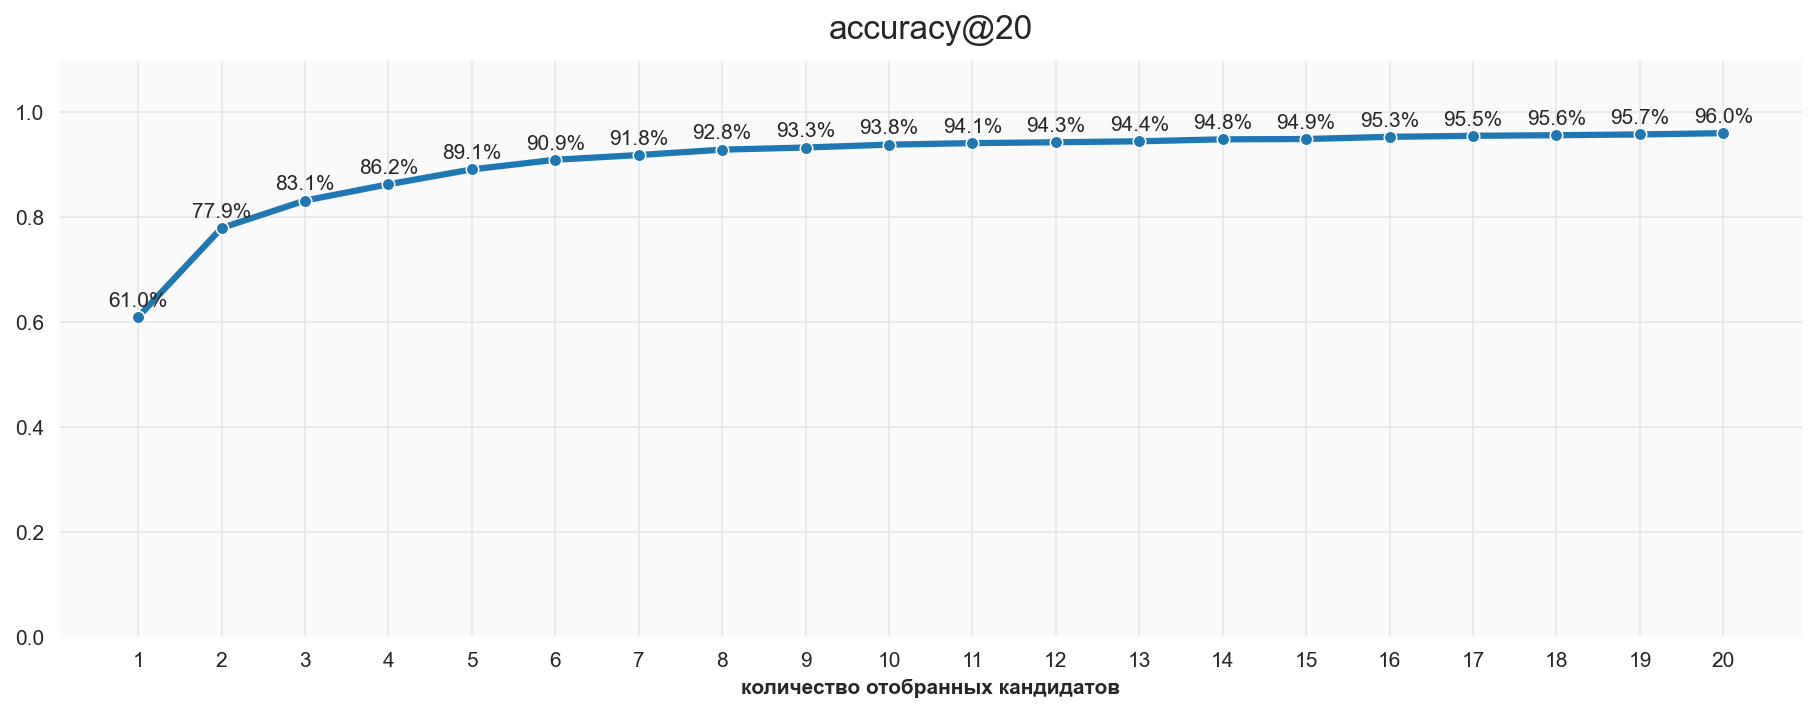

In [51]:
fig, ax = plt.subplots(figsize=(15, 5), dpi=PLOT_DPI)

sns.lineplot(x=range(1, N_TOP+1), y=accuracy_N, linewidth=3, marker='o')

ax.set_xlabel('количество отобранных кандидатов')
ax.set_ylabel('accuracy')
ax.set_ylim(0, 1.1)
ax.set_title(f'accuracy@{N_TOP}')
ax.set_xticks(range(1, N_TOP+1))

for x, y in zip(range(1, N_TOP+1), accuracy_N):
    ax.annotate(f'{y:.1%}', (x, y), textcoords='offset points', xytext=(0,5), ha='center')

plt.show()

In [52]:
accuracy_N[f'match_{N_TOP}']

0.9598438371444507

> По результатам исследования можно рекомендовать показывать **5–8** товаров-кадидатов для мэтчинга.  
> Следующие товары можно временно скрыть и показывать по запросу оператора.

> Достигнут уровень качества поиска на уровне топовых результатов без применения каких-либо улучшающих техник.
>
> Следующим шагом можно исследовать степень влияния улучшающих техник.